## Importing the relevant libraries

In [1]:
! pip install wget --quiet

In [2]:
! pip install tensorflow==2.10.0 --quiet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf, keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from wordcloud import WordCloud
#wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from helper_prabowo_ml import clean_html, punct, remove_digits, remove_links, remove_special_characters, remove_, removeStopWords, lower, email_address, non_ascii
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

2025-04-03 11:39:41.761130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-03 11:39:42.784743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-03 11:39:42.784791: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-04-03 11:39:42.909485: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 11:39:45.166030: W tensorflow/stream_executor/platform/de

## Loading the initials train, test and evaluation datasets

In [4]:
first_train_df = pd.read_csv("src/train.csv",delimiter=';')
first_train_df.drop('Unnamed: 0',axis=1,inplace=True)
first_train_df = first_train_df.dropna().drop_duplicates()
first_train_df.head()
first_test_df = pd.read_csv('src/test.csv',delimiter=';')
first_test_df.drop('Unnamed: 0',axis=1,inplace=True)
first_test_df = first_test_df.dropna().drop_duplicates()
first_test_df.head()
first_evaluation_df = pd.read_csv("src/evaluation.csv",delimiter=';')
first_evaluation_df.drop('Unnamed: 0',axis=1,inplace=True)
first_evaluation_df = first_evaluation_df.dropna().drop_duplicates()
first_evaluation_df.head()

,title,text,label
0,"Sanders back in U.S. Senate, blasts 'coloniali...",WASHINGTON (Reuters) - Democratic U.S. preside...,1
1,Kremlin: Syria peoples' congress being 'active...,MOSCOW (Reuters) - A proposal to convene a con...,1
2,Oregon Cop Convicted Of Shattering Biker’s Co...,"In a baffling fit of rage, an Oregon State Pol...",0
3,Twitter Erupts With Glee Over #CruzSexScandal...,The last thing any politician running for the ...,0
4,MUST WATCH VIDEO: Obama Tries To Trash Trump B...,This is too good to miss! Mr. Teleprompter did...,0


In [5]:
total_len=len(first_train_df)+len(first_test_df)+len(first_evaluation_df)
train_size=len(first_train_df)/total_len
test_size=len(first_test_df)/total_len
evaluation_size=len(first_evaluation_df)/total_len
train_size,test_size,evaluation_size

(0.6000098556152368, 0.1999950721923816, 0.1999950721923816)

## Conbining Fake.csv, True.csv and Welfake data set
### https://zenodo.org/records/4561253

In [6]:
from sklearn.model_selection import train_test_split

welfake_df = pd.read_csv("src/WELFake_Dataset.csv",delimiter=',')
welfake_df.drop('Unnamed: 0',axis=1,inplace=True)

fake_data = pd.read_csv('src/Fake.csv',sep=',',header=0)
cleaned_fake=fake_data.drop(['subject','date'],axis=1)
cleaned_fake['label'] = 0
true_data = pd.read_csv("src/True.csv",delimiter=',')
cleaned_true=true_data.drop(['subject','date'],axis=1)
cleaned_true['label'] = 1

concact_data=pd.concat([welfake_df,cleaned_fake,cleaned_true],ignore_index=True)
concact_data=concact_data.sample(frac=1).reset_index(drop=True)

train_df2, temp_df = train_test_split(concact_data, test_size=(test_size + evaluation_size), random_state=42, stratify=concact_data["label"])
test_df2, eval_df2 = train_test_split(temp_df, test_size=(evaluation_size / (test_size + evaluation_size)), random_state=42, stratify=temp_df["label"])

len(train_df2), len(test_df2), len(eval_df2)

(70220, 23406, 23406)

In [7]:
train_df=pd.concat([first_train_df,train_df2],ignore_index=True)
test_df=pd.concat([first_test_df,test_df2],ignore_index=True)
evaluation_df=pd.concat([first_evaluation_df,eval_df2],ignore_index=True)

train_df.duplicated().sum(), test_df.duplicated().sum(), evaluation_df.duplicated().sum()

(12308, 1501, 1463)

In [8]:
# Remove duplicates
train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)  
evaluation_df.drop_duplicates( inplace=True)

In [9]:
train_df.isna().sum(), test_df.isna().sum(), evaluation_df.isna().sum()

(title    308
 text      24
 label      0
 dtype: int64,
 title    119
 text      10
 label      0
 dtype: int64,
 title    110
 text       5
 label      0
 dtype: int64)

In [10]:
# Remove NaN values 
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
evaluation_df.dropna(inplace=True)



In [11]:
train_df.shape

(81932, 3)

## Data Exploration

In [12]:
train_df['num_words'] = train_df.text.apply(len)
train_df.num_words.describe()

count     81932.000000
mean       2889.610457
std        2939.278430
min           1.000000
25%        1380.000000
50%        2344.000000
75%        3550.000000
max      142961.000000
Name: num_words, dtype: float64

In [13]:
train_df.head()

,title,text,label,num_words
0,Palestinians switch off Christmas lights in Be...,"RAMALLAH, West Bank (Reuters) - Palestinians s...",1,1335
1,China says Trump call with Taiwan president wo...,BEIJING (Reuters) - U.S. President-elect Donal...,1,373
2,FAIL! The Trump Organization’s Credit Score W...,While the controversy over Trump s personal ta...,0,2072
3,Zimbabwe military chief's China trip was norma...,BEIJING (Reuters) - A trip to Beijing last wee...,1,2692
4,THE MOST UNCOURAGEOUS PRESIDENT EVER Receives ...,There has never been a more UNCOURAGEOUS perso...,0,1946


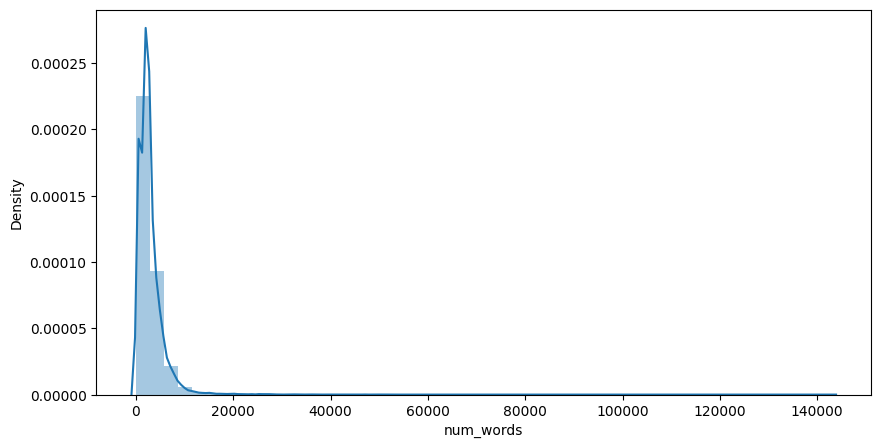

In [14]:
plt.figure(figsize=(10,5))
sns.distplot(train_df['num_words']);

In [15]:
max_len = 120

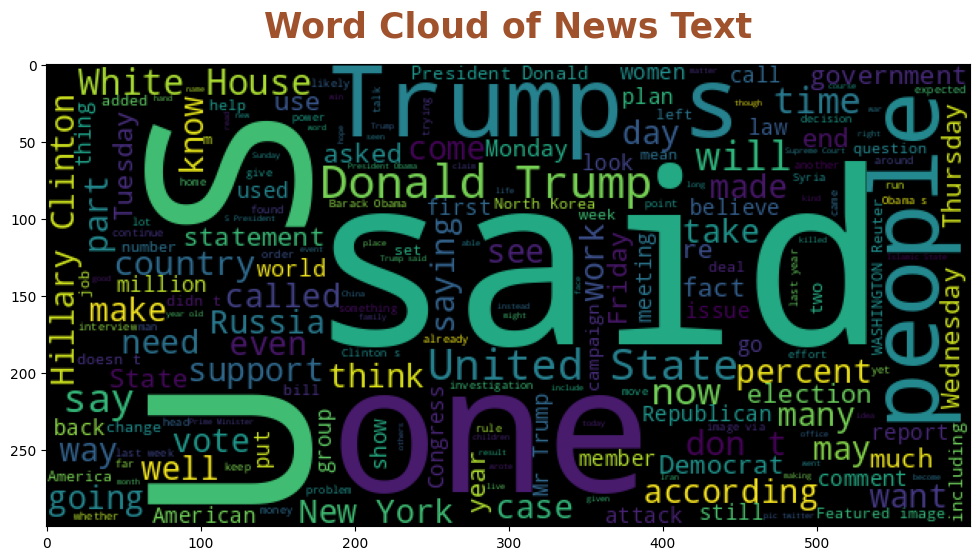

In [16]:
plt.figure(figsize=(12,6))
wc = WordCloud(width=600, height=300, random_state=101, stopwords=WordCloud().stopwords).generate(' '.join(train_df['text'].dropna()))
plt.imshow(wc)
plt.title('Word Cloud of News Text',fontsize=25,pad=20,fontweight='bold',color='sienna')
plt.show();

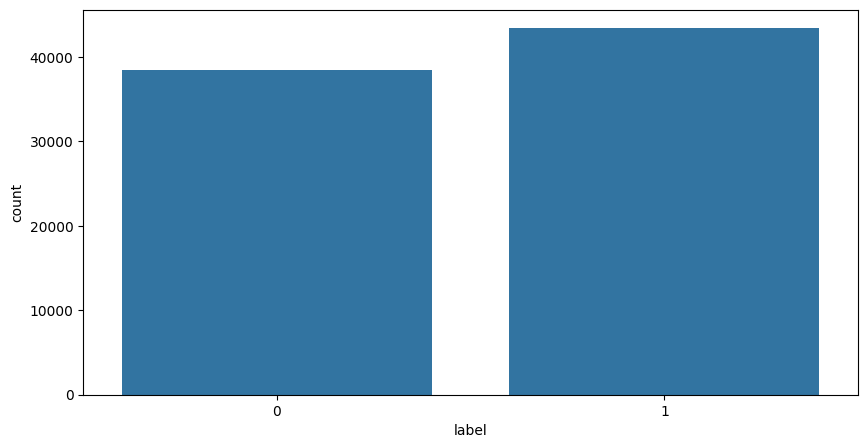

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='label',data=train_df);


The target fake news label is relatively balanced.

## Text Preprocessing

In [18]:
def preprocess_text(data,col):
    data[col] = data[col].apply(func=lower)
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    return data
    
    

In [20]:
preprocessed_train = preprocess_text(train_df, 'text')
preprocessed_test = preprocess_text(test_df,'text')
preprocessed_eval = preprocess_text(evaluation_df,'text')

## Downloading pretrained Tokenizer and BERT model from Hugging Face

In [21]:
model_name = 'mrm8488/bert-tiny-finetuned-fake-news-detection'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = TFAutoModelForSequenceClassification.from_pretrained(model_name,from_pt=True)


2025-04-03 11:47:50.463983: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-04-03 11:47:50.465248: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-03 11:47:50.465334: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (artefact-de-vm-hadjmohamed): /proc/driver/nvidia/version does not exist
2025-04-03 11:47:50.468141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequ

## Performing text tokenization

In [22]:
X_train = tokenizer(text=preprocessed_train.text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   return_tensors='tf',
                   verbose=1)

X_test = tokenizer(text=preprocessed_test.text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  return_tensors='tf',
                  verbose=1)

X_eval = tokenizer(text=preprocessed_eval.text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  return_tensors='tf',
                  verbose=1)



In [23]:
print(X_train)


{'input_ids': <tf.Tensor: shape=(81932, 120), dtype=int32, numpy=
array([[  101, 14115, 18599, ...,  7486,  2408,   102],
       [  101,  7211, 26665, ...,     0,     0,     0],
       [  101,  6704,  8398, ...,  7207,  3192,   102],
       ...,
       [  101,  2250, 16429, ...,  4336,  4736,   102],
       [  101,  2899, 26665, ...,     0,     0,     0],
       [  101,  9810, 26665, ...,  2239,  2231,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(81932, 120), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)>}


## Encoding the target label classes

In [24]:
scaler = LabelEncoder()
train_df.label = scaler.fit_transform(train_df.label)
test_df.label = scaler.transform(test_df.label)
evaluation_df.label = scaler.transform(evaluation_df.label)

## Model Training & Evaluation

In [25]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [26]:
embeddings = bert(input_ids,attention_mask=attention_mask)[0] # 0 -> final hidden state, 1 -> pooling output
output = Flatten()(embeddings)
output = Dense(units=512,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.15)(output)
output = Dense(units=1,activation='sigmoid')(output)
model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 120)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 120)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  4386178    ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 2),                                                 
                                 hidden_states=None                                           

In [27]:
plot_model(model,to_file='model.png',show_shapes=True,dpi=100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
optimizer = Adam(learning_rate=4e-5,epsilon=1e-7,decay=1e-2,clipnorm=1.0)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [29]:
def step_decay(epoch, lr):
    drop_rate = 0.5
    step_size = 10
    return lr * drop_rate ** (epoch // step_size)

In [30]:
es = EarlyStopping(monitor='val_accuracy',mode='max',patience=10,restore_best_weights=True,verbose=1)
lrs = LearningRateScheduler(step_decay,verbose=1)
mc = ModelCheckpoint(filepath='fake_news_classifier.keras',monitor='val_accuracy',save_best_only=True,mode='max',save_freq='epoch',verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=train_df.label,
             epochs=20,
             batch_size=256,
             callbacks=[es,lrs,mc],
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.label)
             )


Epoch 1: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 1/20
321/321 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.5348
Epoch 1: val_accuracy improved from -inf to 0.61359, saving model to fake_news_classifier.keras
321/321 [==============================] - 341s 1s/step - loss: 0.8226 - accuracy: 0.5348 - val_loss: 0.6863 - val_accuracy: 0.6136 - lr: 4.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 2/20
321/321 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.5398
Epoch 2: val_accuracy improved from 0.61359 to 0.61800, saving model to fake_news_classifier.keras
321/321 [==============================] - 342s 1s/step - loss: 0.7971 - accuracy: 0.5398 - val_loss: 0.6757 - val_accuracy: 0.6180 - lr: 4.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.9999998989515007e-05.
Epoch 3/20
321/321 [==============================] - ETA: 0s - loss: 0.

## Visualizing model performance

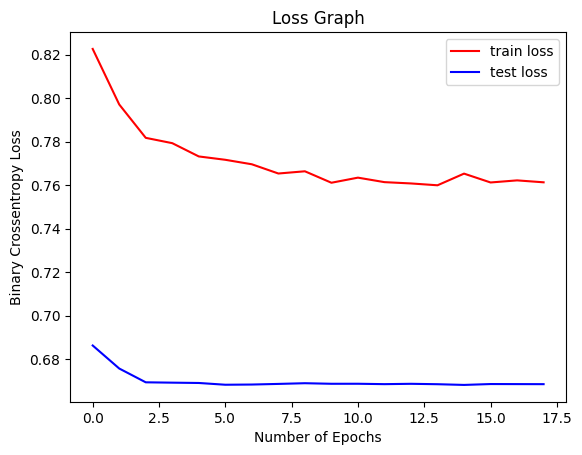

In [31]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

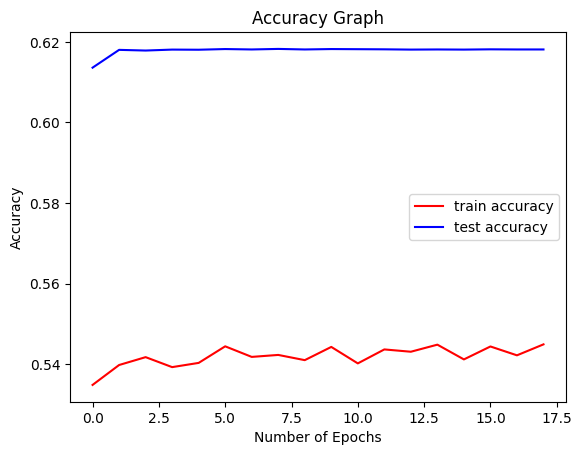

In [32]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

## Evaluating model on the test dataset

In [33]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},test_df.label)
print("Test Binary Crossentropy Loss:", round(loss,2))
print("Test Accuracy:", round(acc*100,2))

935/935 [==============================] - 71s 76ms/step - loss: 0.6686 - accuracy: 0.6182
Test Binary Crossentropy Loss: 0.67
Test Accuracy: 61.82


935/935 [==============================] - 71s 75ms/step
Confusion Matrix:
[[9919 4588]
 [6824 8562]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63     14507
           1       0.65      0.56      0.60     15386

    accuracy                           0.62     29893
   macro avg       0.62      0.62      0.62     29893
weighted avg       0.62      0.62      0.62     29893



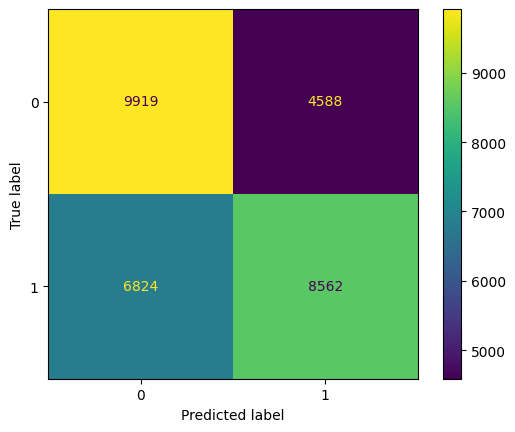

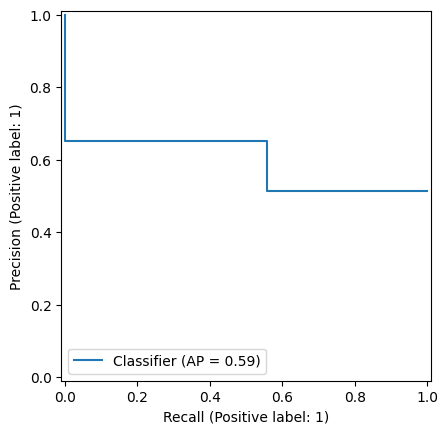

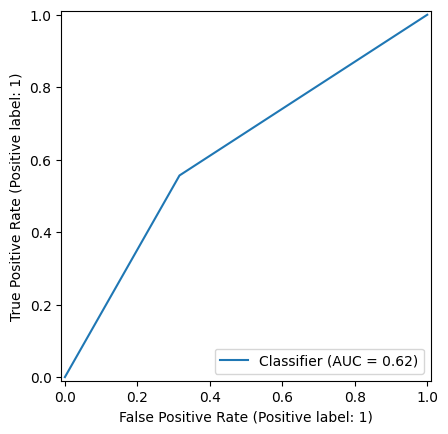

In [34]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = (test_predictions > 0.5).astype('float')
print("Confusion Matrix:")
print(confusion_matrix(test_df.label,test_predictions))
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))
ConfusionMatrixDisplay.from_predictions(test_df.label,test_predictions)
plt.show()
PrecisionRecallDisplay.from_predictions(test_df.label,test_predictions)
plt.show()
RocCurveDisplay.from_predictions(test_df.label,test_predictions)
plt.show()

## Model Inference

936/936 [==============================] - 70s 75ms/step
Confusion Matrix:
[[9964 4619]
 [6931 8431]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.68      0.63     14583
           1       0.65      0.55      0.59     15362

    accuracy                           0.61     29945
   macro avg       0.62      0.62      0.61     29945
weighted avg       0.62      0.61      0.61     29945



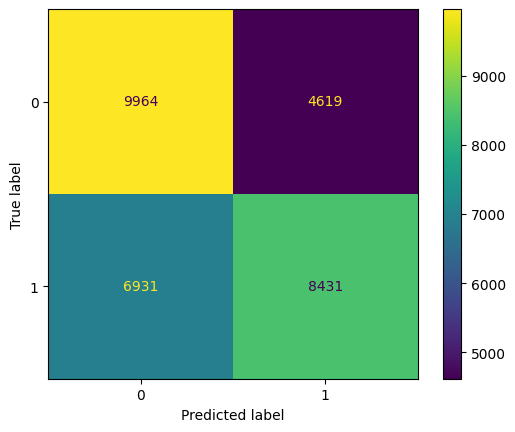

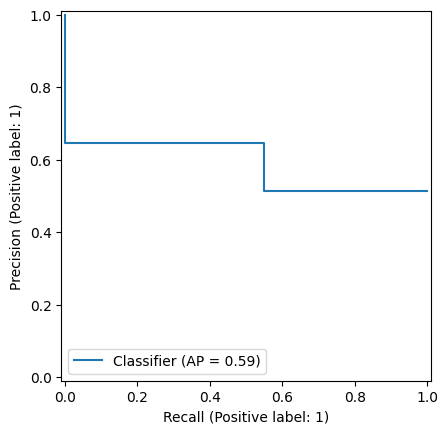

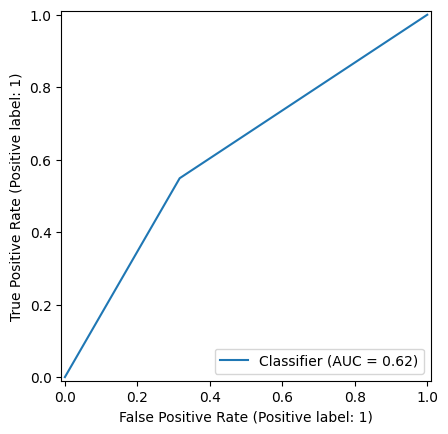

In [35]:
test_predictions = model.predict({'input_ids': X_eval['input_ids'], 'attention_mask': X_eval['attention_mask']})
test_predictions = (test_predictions > 0.5).astype('float')
print("Confusion Matrix:")
print(confusion_matrix(evaluation_df.label,test_predictions))
print("Classification Report:")
print(classification_report(evaluation_df.label,test_predictions))
ConfusionMatrixDisplay.from_predictions(evaluation_df.label,test_predictions)
plt.show()
PrecisionRecallDisplay.from_predictions(evaluation_df.label,test_predictions)
plt.show()
RocCurveDisplay.from_predictions(evaluation_df.label,test_predictions)
plt.show()

Bravo! The model has performed incredibly well by achieving an astonishing accuracy of more than 97% on the evaluation holdout set.

Don't forget to upvote my notebook if you like it! If you have any feedback, kindly share it in the comments section below.

In [36]:
tokenizer.save_pretrained(save_directory='tokenizer/') # Saving the pretrained tokenizer

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [37]:

# Save in HDF5 format (alternative)
model.save("fakenews_prediction_model.h5")


In [ ]:
# Load complete model
from transformers import TFBertForSequenceClassification

# Load in HDF5 format (alternative)
tf.keras.utils.get_custom_objects().update({
    'TFBertForSequenceClassification': TFBertForSequenceClassification
})
loaded_model = tf.keras.models.load_model("fakenews_prediction_model.h5")
  

In [ ]:
# Chargement du modèle et du tokenizer
tokenizer = AutoTokenizer.from_pretrained("tokenizer_trained")

# Chargement du tokenizer
def predict_text(text, threshold=0.5):
    """
    Prédiction sur un texte donné avec le modèle NLP chargé.
    :param text: Texte à analyser
    :param threshold: Seuil de classification (0.5 par défaut)
    :return: Score de probabilité et classe (Fake News ou Non)
    """
    # Tokenisation
    tokenized_input = tokenizer(text,
                            max_length=max_len,
                            padding="max_length",  # Ensures the input is padded to max_len
                            truncation=True,
                            add_special_tokens=True,
                            return_token_type_ids=False,
                            return_attention_mask=True,
                            return_tensors='tf')


    
    # Prédiction
    prediction = loaded_model(tokenized_input)
   
    # Application de la fonction sigmoid (si nécessaire)
    #scores = tf.nn.sigmoid(prediction.logits).numpy()
    scores = tf.nn.sigmoid(prediction).numpy()
    #scores = tf.nn.sigmoid(prediction.logits).numpy()

    # Conversion en classe binaire
    predicted_class = (scores > threshold).astype(float)

    return {"score": scores[0][0], "prediction": "FAKE NEWS" if predicted_class[0][0] == 0 else "REAL NEWS"}

# Exemple d'utilisation
text_example = "While the controversy over Trump s personal tax returns continues, business credit rating company Nav decided to take a look at his business  credit, and published the results on their website. Nav, which actually does have an A+ rating from the Better Business Bureau (as opposed to Trump U. s final rating), pulled together the factors affecting business credit scores and discovered something truly laughable.The highest possible business score is 100. The Trump Organization s score is 19. Nineteen. As in more than 15 but less than 20, and it s actually dropped 18 points. This puts the company in the medium to high-risk category:The organization is considered highly likely to default on its debts, and it averages sending payments 17 days late. They also have six derogatories, which can be delinquent loans that have been turned over to collections, as well as tax liens and judgments against the organization. According to Nav, that last one usually means the business was the defendant in a lawsuit and is now required to pay damages to the plaintiff.Compare that to the Clinton Foundation, which has a score of 42. 42 isn t great, but it s a hell of a lot better than the Trump Organization s.*Note: The Clinton Foundation has been around since 1997, but has only been known in its current form for the last three years.Despite not having stellar credit either, the Clinton Foundation also has no derogatories and makes its payments on time.This whole thing is laughable considering the wonderful businessman Trump seems to think he is. It s even more laughable considering that Trump says nobody knows debt better than he does. In August, he boasted that he has  very little debt  relative to his assets.Regardless of whether that s true, the fact that the Trump Organization s credit score is so low suggests that Trump is either not nearly as good at managing what debt he does have as well as he claims, or he s not nearly as good at managing his businesses as well as he claims.This credit score is hilarious.Featured image by Scott Olson via Getty Images"
# Ensure the input is padded to the expected max_len

# Update the prediction logic to pass the correct input shape
result = predict_text(text_example)

# Update the prediction logic to handle the output of the loaded_model correctly

print(result)
